# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gc

%matplotlib inline
sns.set()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler #, OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
     .builder \
     .master('local') \
     .appName("Sparkify") \
     .config("spark.executor.memory", '8g') \
     .config("spark.driver.memory", '8g') \
     .getOrCreate()
     
     #.config('spark.driver.maxResultSize', '4G') \
     #.config("spark.sql.broadcastTimeout", "72000") \
     #.config("spark.dynamicAllocation.enabled", "true") \
     #.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
     #.config("spark.shuffle.spill.compress", "true") \
     #.config("spark.shuffle.service.enabled", "true") \
     #.config("spark.io.compression.codec", "snappy") \
     #.config("spark.driver.memory", "16g") \
     #.config("spark.driver.cores", "6") \
     #.config("spark.executor.cores", "6") \
     #.config("spark.executor.memory", "16g") \
     #.config("spark.kryoserializer.buffer.max", "2000m") \
     #.config("spark.network.timeout", "360000") \
     #.config("spark.dynamicAllocation.minExecutors", "25")\
     #.enableHiveSupport() \
     #.config("spark.sql.shuffle.partitions", "1000") \
     

In [3]:
#check installed spark version
print('Version: ', spark.version)

Version:  3.0.2


# Code Prep
In this workspace, all code that is used throughout the notebook is defined.

In [4]:
def load_data(path=''):
    """
    This function loads json data

    Args:
        - path (string): filepath to the data
    Returns:
        - data (json): spark json file
    """
    #create json data from filepath
    data = spark.read.json(path)

    return data

In [5]:
def clean_data(data):
    """
    This function cleans the dataset:
        - delete rows without userIds or sessionIds
        - cast userId to LongType
        - replace special characters of string columns with empty string
        - split ts into useable columns interaction_time, month, date
        - delete ts column (depricated)
        - split location into seperate columns location, state

    Args:
        data (json): loaded json file
    Returns:
        cleaned_data (json): cleaned json file
    """
    #delete rows without userids or sessionids
    data = data.filter(col('userId').isNotNull() | col('sessionId').isNotNull())

    #cast userId to LongType
    data= data.withColumn("userId", data["userId"].cast(IntegerType()))
    data= data.withColumn("sessionId", data["sessionId"].cast(IntegerType()))

    #replace special characters of strings with empty
    for field in data.schema.fields:
        if field.dataType==StringType():
            data = data.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9 \n\.]', ''))
    
    # split ts into useable columns interaction_time, month, date
    data = data.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    data = data.withColumn('month', month(col('interaction_time')))
    data = data.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

    #split location into seperate columns location, state
    data = data.withColumn('state', split(col('location'), ' ').getItem(1))
    data = data.withColumn('location', split(col('location'),' ').getItem(0))

    #split userAgent for operating system
    data = data.withColumn('operating_system', split(col('userAgent'), ' ').getItem(1))

    #substitute NaN values in column length with average
    data = data.fillna(0, subset=['length'])

    #create new copy
    cleaned_data = data

    return cleaned_data

In [6]:
def check_nan(data):
    """
    This function checks a spark dataframe for nan values

    Args:
        - data (json): input data
    Returns:
        - None
    """
    #check data for nan values
    data.select([count(when(isnan(c), c)).alias(c) for (c, c_type) in data.dtypes if c_type not in ('timestamp', 'string', 'date')]).show()

In [7]:
def show_data(data, n_rows=5):
    """
    This function shows data as a Pandas Dataframe

    Args:
        - data : input data
        - n_rows: number of rows to show
    Returns:
        - df: Pandas DataFrame to show
    """
    df = pd.DataFrame(data.take(n_rows), columns=data.columns)

    return df

In [8]:
def add_churn(data):
    """
    This functions adds a new column churn to the cleaned data, based on the Cancellation Confirmation events, 
    which happen to both paid and free users.

    Args:
        - data (json): provided data
    Returns:
        - data (json): with added column churn
    """
    #compute churn on pagetypes and auth
    churn = cleaned_data.withColumn('churn', when((col('page').isin(['Cancellation Confirmation', 'Cancel'])) | (col('auth') == 'Cancelled'), 1 ).otherwise(0)).groupby                  ('userId').agg(sum('churn').alias('churn')).withColumn('churn', when(col('churn') >= 1, 1).otherwise(0))

    #join new df churn with cleaned_data
    churn_data = data.join(churn, on='userId')
    
    return churn_data

In [9]:
def dataframe_shape(data):
    """
    This function displays the shape of a pyspark DataFrame

    Args:
        - data (Pandas Dataframe): input data
    Returns:
        - None
    """
    print((data.count(), len(data.columns)))

In [10]:
class Plots:
    """
    Can derive different graphs to plot.

    Args:
        - values (Pandas DataFrame): input values
        - x_values (list): input values
        - y_values (list): input values
        - x_label (string): name for x_axis
        - y_label (string): name for y_axis
        - title (string): title for plot
        - hue (string): defines column for color coding
        - data (Pandas DataFrame): input data
        - bin_min (int): minimum for bin for histograms
        - bin_max (int): maximum for bin for histograms
        - bin_step (int): step size for bin for histogram
        - fig_width (int): width for figure
        - fig_height (int): height for figure
    """
    
    #define the __init__
    def __init__(self, x_values=[], y_values=[], values=pd.DataFrame(), x_label='', y_label='', title='', \
        hue=[], data=pd.DataFrame(), bin_min=0, bin_max=140, bin_step=5, fig_width=15, fig_height=10):
        self.x_values = x_values
        self.y_values = y_values
        self.values = values
        self.x_label = x_label
        self.y_label = y_label
        self.title = title
        self.hue = hue
        self.data = data
        self.bin_min = bin_min
        self.bin_max = bin_max
        self.bin_step = bin_step
        self.fig_width = fig_width
        self.fig_height = fig_height
        
    
    #generic Histogram function
    def plot_histogram(self):
        """
        The function plots a histogram for user interactions with articles on IBM Watson.
        It saves the histogram as a PNG-file

        Args:
            values (df): df of user interactions with articles
            x_label (string): label for x-axis
            y_label (string): label for y_axis
            title (string): label for plot
            bin_min (int): min range for x-axis
            bin_max (int): max range for x_axis
            bin_step (int): step size for x_axis
        Returns:
            None
        """
        #determine number of bins for histogram
        bins = np.arange(self.bin_min, self.bin_max, self.bin_step)

        #specify plot style from seaborn library
        plt.style.use('fivethirtyeight')

        #specify figsize
        plt.figure(figsize=(self.fig_width, self.fig_height))

        #plot the graph
        plt.hist(self.values, bins=bins, rwidth=.8, alpha=.8)

        #specify title
        plt.title(self.title)

        #specify label x-axis
        plt.xlabel(self.x_label)

        #specify label y-axis
        plt.ylabel(self.y_label)
    
    #sns barplot
    def sns_barplot(self):
        """
        This functions plots a barplot with seaborn
        """
        sns.barplot(x=self.x_values, y=self.y_values, hue=self.hue, data=self.data)

    #barplot with matplotlib.pyplot
    def barplot(self):
        """
        This function plots a barplot with matplotlib.pyplot
        """
        self.data.plot.bar(self.x_values, figsize=(self.fig_width, self.fig_height))

In [11]:
def show_gender_churn_dist():
    """
    This functions plots the distriution of deduplicated users in the dataset across genders for churn or non churn

    Args:
        - None
    Returns:
        - gender_churn_df
    """
    #distribution of churns users and normal users, deduplicated
    gender_churn_df = churn_data.dropDuplicates(['userId', 'gender']).groupBy('churn', 'gender').count().toPandas()

    #create barplot
    gender_churn_barplot = Plots(x_values='churn', y_values='count', hue='gender', data=gender_churn_df)
    gender_churn_barplot.sns_barplot()

    return gender_churn_df

In [12]:
def page_use_distribution():
    """
    This function shows the distribution of pageuse between churn users and non churn users

    Args:
        -  None
    Returns:
        - churn_page_df
        - non_churn_page_df
    """
    #count churns and non churns
    churn_count = churn_data.where(churn_data['churn'] == 1).count()
    non_churn_count = churn_data.where(churn_data['churn'] == 0).count()

    #create two df with pages and number of interactions for all pages
    #filter out page "NextSong" for more even distribution
    churn_page_df = churn_data.where((churn_data['churn'] == 1) & (churn_data['page'] != 'NextSong')).groupby(['page']).count()
    non_churn_page_df = churn_data.where((churn_data['churn'] == 0) & (churn_data['page'] != 'NextSong')).groupby(['page']).count()

    #compute frequency of use
    churn_page_df = churn_page_df.withColumn('churn_frequency', churn_page_df['count']/(churn_count/100)).sort('page').drop('count').toPandas()
    non_churn_page_df = non_churn_page_df.withColumn('non_churn_frequency', non_churn_page_df['count']/(non_churn_count/100)).sort('page').drop('count').toPandas()

    #create new df with results
    page_use_dist = churn_page_df
    page_use_dist['non_churn_frequency'] = non_churn_page_df['non_churn_frequency']
    page_use_dist.fillna(0)

    #create barplot
    page_use_dist_barplot = Plots(x_values='page', data=page_use_dist, fig_width=10, fig_height=5)
    page_use_dist_barplot.barplot()

    return churn_page_df, non_churn_page_df

In [13]:
def churn_level():
    """
    This function shows the payment level for the time the users churned

    Args:
        - None
    Returns:
        - churn_level_df
    """
    #level of user when churn happened
    churn_level_df = churn_data.where(churn_data['page'] == 'Cancellation Confirmation').groupby('level').count().toPandas()

    #create barplot
    churn_level_barplot = Plots(x_values='level', y_values='count', hue='level', data=churn_level_df)
    churn_level_barplot.sns_barplot()

    return churn_level_df

In [14]:
def num_registered_days(data):
    """
    This function calculates the number of registered days between registration and the last user interaction

    Args:
        - data (json): input data
    Returns:
        - data (json): input data plus new column with num_registered_days
    """
    #create new DataFrame with timestamp of last interaction for each userId
    last_interaction_data = data.groupBy('userId').agg(max('ts').alias('last_interaction'))

    #join new DataFrame with data and compute registered_days
    registered_days_data = last_interaction_data.join(data, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000)\
        .cast(IntegerType())).dropDuplicates()

    return registered_days_data

In [15]:
def num_thumbsup(data):
    """
    This function calculates the number of "Thumbs Up" or "Likes" a user has dealt out.

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column num_thumbsup
    """
    #create a new DataFrame with count of Thumbs Up
    thumbsup_data = data.where(data['page']=='Thumbs Up').groupby('userId').count().withColumnRenamed('count', 'num_thumbsup')
    
    #join with input data
    num_thumbsup_data = data.join(thumbsup_data, on='userId').dropDuplicates()

    #cast as integer
    num_thumbsup_data = num_thumbsup_data.withColumn("num_thumbsup", num_thumbsup_data["num_thumbsup"].cast(IntegerType()))

    return num_thumbsup_data

In [16]:
def num_thumbsdown(data):
    """
    This function calculates the number of "Thumbs Down" or "Dislikes" a user has dealt out.

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column num_thumbsdown
    """
    #create a new DataFrame with count of Thumbs Down
    thumbsdown_data = data.where(data['page']=='Thumbs Down').groupby('userId').count().withColumnRenamed('count', 'num_thumbsdown')
    
    #join with input data
    num_thumbsdown_data = data.join(thumbsdown_data, on='userId').dropDuplicates()

    #cast as integer
    num_thumbsdown_data = num_thumbsdown_data.withColumn("num_thumbsdown", num_thumbsdown_data["num_thumbsdown"].cast(IntegerType()))

    return num_thumbsdown_data

In [17]:
def num_add_friend(data):
    """
    This function calculates the number of "Add Friend" .

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column num_add_friend
    """
    #create a new DataFrame with count of Thumbs Down
    friend_data = data.where(data['page']=='Add Friend').groupby('userId').count().withColumnRenamed('count', 'num_add_friend')

    #join with input data
    num_friend_data = data.join(friend_data, on='userId').dropDuplicates()

    #cast as integer
    num_friend_data = num_friend_data.withColumn("num_add_friend", num_friend_data["num_add_friend"].cast(IntegerType()))

    return num_friend_data

In [18]:
def payment_level(data):
    """
    This function computes the most recent payment level for each user 
    and adds a new column to the input data

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column payment_level
    """
    #create new DataFrame with the most recent payment level for each user
    payment_level_data = data.orderBy('ts').groupBy('userId').agg(first('level').alias('payment_level'))

    #turn free and paid into 0, 1
    payment_level_data = payment_level_data.select('userId', 'payment_level').dropDuplicates().replace(['free', 'paid'], ['0', '1'], 'payment_level')

    #join with input data
    payment_data = data.join(payment_level_data, on='userId').dropDuplicates()

    #cast as integer
    payment_data = payment_data.withColumn("payment_level", payment_data["payment_level"].cast(IntegerType()))

    return payment_data

In [19]:
def avg_songs(data):
    """
    This function computes the average number of songs per user per session

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column avg_songs_per_session
    """
    #create new DataFrame with userId and count of Songs in a session
    #create new DataFrame with userId and average number of songs
    user_session_songs_data = data.where(data['page']=='NextSong').groupby('userId', 'sessionId').count()\
                            .groupby('userId').agg(avg('count').alias('avg_songs_per_session'))

    #join with input data
    avg_songs_data = data.join(user_session_songs_data, on='userId').dropDuplicates()

    #cast as integer
    avg_songs_data = avg_songs_data.withColumn("avg_songs_per_session", avg_songs_data["avg_songs_per_session"].cast(IntegerType()))

    return avg_songs_data

In [20]:
def avg_length(data):
    """
    This function computes the average length for every user

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column avg_length
    """
    #calculate average length for each user
    length_data = data.groupby('userId').agg(avg('length').alias('avg_length'))

    #join with input data
    avg_length_data = data.join(length_data, on='userId').dropDuplicates()

    #cast as integer
    avg_length_data = avg_length_data.withColumn("avg_length", avg_length_data["avg_length"].cast(IntegerType()))

    return avg_length_data

In [21]:
def num_sessions(data):
    """
    This functions calculates the total number of sessions for each user

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column num_sessions
    """
    #calculate total number of sessions for each userId
    session_data = data.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')

    #join with input data
    num_sessions_data = data.join(session_data, on='userId').dropDuplicates()

    #cast as integer
    num_sessions_data = num_sessions_data.withColumn("num_sessions", num_sessions_data["num_sessions"].cast(IntegerType()))

    return num_sessions_data

In [22]:
def gender(data):
    """
    This functions marks the gender as either 0 or 1 and drops the original column gender

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column type_gender
    """
    #calculate the type of gender as either 0 (M) or 1 (F)
    gender_data = data.select('userId', 'gender').dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').withColumnRenamed('gender', 'type_gender')

    #join with input data
    type_gender_data = data.join(gender_data, on='userId').dropDuplicates()

    #cast as integer
    type_gender_data = type_gender_data.withColumn("type_gender", type_gender_data["type_gender"].cast(IntegerType()))

    return type_gender_data

In [23]:
def auth_status(data):
    """
    This functions marks the auth_status as either 0 (logged out) or 1 (logged in)

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column type_auth
    """
    #calculate the type of auth as either 0 (logged out) or 1 (logged in)
    auth_data = data.select('userId', 'auth').dropDuplicates().replace(['Logged Out', 'Logged In', 'Cancelled'], ['0', '1', '2'], 'auth').withColumnRenamed('auth', 'type_auth')

    #join with input data
    type_auth_data = data.join(auth_data, on='userId').dropDuplicates()

    #cast as integer
    type_auth_data = type_auth_data.withColumn("type_auth", type_auth_data["type_auth"].cast(IntegerType()))

    return type_auth_data

In [24]:
def num_artists(data):
    """
    This function computes the total number of artists a user has heard

    Args:
        - data (json): input data
    Returns:
        - data (json): input data with new column num_artists
    """
    #compute the number of artists heard by a user
    artists_data = data.where(data['page'] == 'NextSong').select('userId', 'artist').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_artists')

    #join with input data
    num_artists_data = data.join(artists_data, on='userId').dropDuplicates()

    #cast as integer
    num_artists_data = num_artists_data.withColumn("num_artists", num_artists_data["num_artists"].cast(IntegerType()))

    return num_artists_data

In [25]:
def get_churn(data):
    """
    This function extracts the userId and churn from churn_data

    Args:
        - data (json): input data
    Returns:
        - data (json): userId and churn
    """
    churn_data = data.select('userId', 'churn')

    #cast as integer
    churn_data = churn_data.withColumn("churn", churn_data["churn"].cast(IntegerType()))

    return churn_data

In [26]:
def create_features_data(data):
    """
    This function joins together the features DataFrame

    Args:
        - data (json): input data
    Returns:
        - data (json): final DataFrame with all features
    """ 
    #join all feature DataFrames together
    features_data = num_registered_days(data)
    features_data = avg_songs(features_data)
    features_data = avg_length(features_data)
    features_data = num_sessions(features_data)
    features_data = gender(features_data)
    features_data = auth_status(features_data)
    features_data = num_artists(features_data)
    features_data = num_thumbsup(features_data)
    features_data = num_thumbsdown(features_data)
    #features_data = num_add_friend(features_data)

    #drop unnecessary columns
    features_data = features_data.drop('auth', 'level','length','userAgent','month','date','interaction_time','registration', 'ts','song','page','sessionId','artist','firstName','lastName','method','status', 'gender', 'location', 'itemInSession')

    #drop duplicates
    features_data = features_data.dropDuplicates()

    features_data = features_data.drop('userId')
    
    return features_data

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [27]:
#load data
data = load_data(path='mini_sparkify_event_data.json')

In [28]:
#clean data
cleaned_data = clean_data(data)

In [29]:
#display first 5 rows of cleaned data as pandas df
show_cleaned_data_df = show_data(cleaned_data, n_rows=5)
show_cleaned_data_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,interaction_time,month,date,state,operating_system
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,Bakersfield,PUT,...,Rockpools,200,1538352117000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,30,2018-10-01 02:01:57,10,2018-10-01,CA,Windows
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,BostonCambridgeNewton,PUT,...,Canada,200,1538352180000,Mozilla5.0 Windows NT 6.1 WOW64 AppleWebKit537...,9,2018-10-01 02:03:00,10,2018-10-01,MANH,Windows
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,Bakersfield,PUT,...,Time For Miracles,200,1538352394000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,30,2018-10-01 02:06:34,10,2018-10-01,CA,Windows
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,BostonCambridgeNewton,PUT,...,Knocking On Forbidden Doors,200,1538352416000,Mozilla5.0 Windows NT 6.1 WOW64 AppleWebKit537...,9,2018-10-01 02:06:56,10,2018-10-01,MANH,Windows
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,Bakersfield,PUT,...,Harder Better Faster Stronger,200,1538352676000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,30,2018-10-01 02:11:16,10,2018-10-01,CA,Windows


In [30]:
#check cleaned_data for nan values
check_nan(cleaned_data)

+-------------+------+------------+---------+------+---+------+-----+
|itemInSession|length|registration|sessionId|status| ts|userId|month|
+-------------+------+------------+---------+------+---+------+-----+
|            0|     0|           0|        0|     0|  0|     0|    0|
+-------------+------+------------+---------+------+---+------+-----+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
#add churn column
churn_data = add_churn(cleaned_data)

In [32]:
#shape of churn_data dataframe
dataframe_shape(churn_data)

(278154, 24)


In [33]:
#show data
show_churn_data_df = show_data(churn_data, n_rows=5)
show_churn_data_df

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,song,status,ts,userAgent,interaction_time,month,date,state,operating_system,churn
0,30,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,Bakersfield,...,Rockpools,200,1538352117000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,2018-10-01 02:01:57,10,2018-10-01,CA,Windows,0
1,9,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,BostonCambridgeNewton,...,Canada,200,1538352180000,Mozilla5.0 Windows NT 6.1 WOW64 AppleWebKit537...,2018-10-01 02:03:00,10,2018-10-01,MANH,Windows,0
2,30,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,Bakersfield,...,Time For Miracles,200,1538352394000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,2018-10-01 02:06:34,10,2018-10-01,CA,Windows,0
3,9,Enigma,Logged In,Micah,M,80,Long,262.71302,free,BostonCambridgeNewton,...,Knocking On Forbidden Doors,200,1538352416000,Mozilla5.0 Windows NT 6.1 WOW64 AppleWebKit537...,2018-10-01 02:06:56,10,2018-10-01,MANH,Windows,0
4,30,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,Bakersfield,...,Harder Better Faster Stronger,200,1538352676000,Mozilla5.0 Windows NT 6.1 WOW64 rv31.0 Gecko20...,2018-10-01 02:11:16,10,2018-10-01,CA,Windows,0


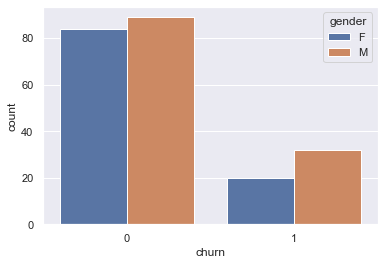

In [34]:
#distribution of churn users and normal users, deduplicated
gender_churn_df = show_gender_churn_dist()

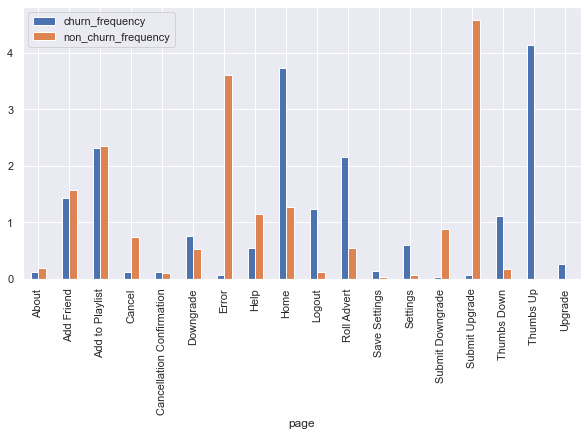

In [35]:
#distribution of page use for churn users and normal users
churn_page_df, non_churn_page_df = page_use_distribution()

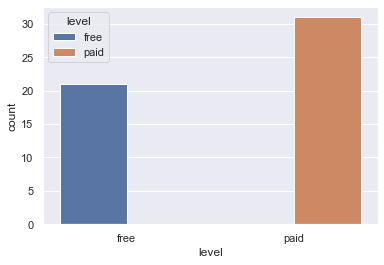

In [36]:
#payment plan when users churned
churn_level_df = churn_level()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [37]:
#Feature 1: Number of days between first registration and latest user interaction
#Feature 2: most recent payment level
#Feature 3: average number of songs per session
#Feature 4: average length of each user
#Feature 5: number of sessions for each user
#Feature 6: gender as 0, 1
#Feature 7: auth status as 0, 1
#Feature 8: number of artists heard
#Feature 9: number of "Thumbs Up" for each user
#Feature 10: number of "Thumbs Down" for each user
#Feature 11: number of "Add Friend" for each user (currently deactivated due to memory)
features_data = create_features_data(churn_data)

In [38]:
features_data.show()

+----------------+----------------+----------------+-----+---------------+---------------------+----------+------------+-----------+---------+-----------+------------+--------------+
|last_interaction|           state|operating_system|churn|registered_days|avg_songs_per_session|avg_length|num_sessions|type_gender|type_auth|num_artists|num_thumbsup|num_thumbsdown|
+----------------+----------------+----------------+-----+---------------+---------------------+----------+------------+-----------+---------+-----------+------------+--------------+
|   1543589607000|  LauderdaleWest|         Windows|    0|             70|                   33|       188|          12|          0|        1|        350|          28|             3|
|   1543603730000|     AngelesLong|       Macintosh|    0|            109|                   90|       208|          41|          0|        1|       2123|         192|            38|
|   1543108803000|YorkNewarkJersey|       Macintosh|    0|            123|           

In [39]:
#delete unused DataFrames from memory
del churn_level_df, churn_page_df, cleaned_data, data, gender_churn_df, non_churn_page_df, show_churn_data_df, show_cleaned_data_df, churn_data
gc.collect()

3259

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [40]:
def create_pipeline(data):
    """
    This function creates the pipeline for ML.
    It adds a string indexer for categorical data and vector assembler for numerical data

    Args:
        - data (json): inpt data from features_data
    Returns:
        - pipeline
    """
    #create list of columns for vector assembler
    cols = []
    
    for field in data.schema.fields :
        if field.dataType!=StringType():
            cols.append(field.name)

    #remove label from list of features
    cols.remove('churn')    

    #create indexes for categorical features
    string_indexer_state = StringIndexer(inputCol='state', outputCol='index_state')
    string_indexer_operating_system = StringIndexer(inputCol='operating_system', outputCol='index_operating_system')
    
    #create vector assembler of numerical features
    vector_assembler = VectorAssembler(inputCols=cols, outputCol='features')

    #create pipeline
    pipeline = Pipeline(stages=[string_indexer_state, string_indexer_operating_system, vector_assembler])

    return pipeline

In [41]:
#create a pipeline with features data
pipeline = create_pipeline(features_data)

In [42]:
def fit_transform_pipeline(data, pipeline):
    """
    This functions fits and transforms a pipeline

    Args:
        - data (json): input data on which to do the fit and transform
        - pipeline: custom pipeline with features data
    Returns:
        - model_data (json): data for the ML
    """
    #fit and transform the pipeline on the feature data
    model_data = pipeline.fit(data).transform(data)

    return model_data

In [43]:
#fit and transform the pipeline with features data
model_data = fit_transform_pipeline(features_data, pipeline)

In [44]:
def train_test_split(data):
    """
    This function splits the given data into trian, test and validation datasets

    Args:
        - data (json): input data
    Returns:
        - train (json): subset of input data for training
        - test (json): subset of input data for test
        - validation (json): subset of inpt data for validating training
    """
    #extract features vector and label for ML
    data = data.select(col("churn").alias("label"), col("features").alias("features"))

    # Split the data into train, test and validation
    train, test = data.randomSplit([.8, .2], seed=42)

    return train, test

In [45]:
#split the model data into trian, test and validation data
train, test = train_test_split(model_data)

In [47]:
def simple_predict(train, test):
    """
    This function does the prediction on the features vector and label.

    Args:
        - train: training data
        - test: test data
    Returns:
        - clf: fitted data
        - preds: predicted values
    """
    #define the model with "churn" as label column
    model = RandomForestClassifier()

    #fit model on training data
    clf = model.fit(train)

    #create predictions on validation data
    preds = clf.transform(test)

    return clf, preds

In [48]:
#create classifier and prediction on RandomForestClassifier
clf, preds = simple_predict(train, test)

In [ ]:
def evaluate_simple_predict(preds):
    """
    This function evaluates the simple_predict model for accuracy and f1-score

    Args:
        - preds: predicted values through ML model
    Returns:
        - None
    """
    #evaluate model prediction accuracy and f1 score
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('Random Forest Classifier Metrics:')
    print('Accuracy: {}'.format(evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(preds, {evaluator.metricName: "f1"})))

In [49]:
#evaluate the simple RandomForestClassifier model
evaluate_simple_predict(preds)

Logistic Regression Metrics:
Accuracy: 0.9591836734693877
F-1 Score:0.9591836734693877


In [50]:
def advanced_predict(train, test):
    """
    This function does ML using ParamGrid and CrossValidation

    Args:
        - train (json): input training data
        - test (json): input test data
    Returns:
        - cvModel: trained model
        - preds: predictions
    """
    #define classifier
    clf = RandomForestClassifier()

    #define parameter grid for optimization
    paramGrid = ParamGridBuilder() \
    .addGrid(clf.numTrees,[20, 25]) \
    .addGrid(clf.maxDepth,[10, 15]) \
    .build()

    #define crossvalidator
    crossval = CrossValidator(estimator=Pipeline(stages=[clf]),
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    
    #fit the training data to the crossvalidator
    cvModel= crossval.fit(train)

    #predict values on test data
    preds = cvModel.transform(test)

    return cvModel, preds

In [51]:
#create clf and prediction on RandomForestClassifier with ParamGrid, CrossValidation
#search for best model with numTrees and maxDepth META-parameters
cvModel, adv_preds = advanced_predict(train, test)

In [52]:
#get right predictions vs actual values
print(adv_preds.filter(adv_preds.label == adv_preds.prediction).count())
print(adv_preds.count())

48
49


In [53]:
#compute accuracy of best model
48/49

0.9795918367346939

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.